In [1]:
# load pandas
import pandas as pd
# load pyplot
from matplotlib import pyplot as plt
# import zeros from numpy
import numpy as np
# import minimize
from scipy.optimize import minimize

In [2]:
#Load data from L3, OPAL and TPC collaborations
L3_data = pd.read_csv("gammagammaSigma_L3_raw.txt", sep = '\t')
OPAL_data = pd.read_csv("gammagammaSigma_OPAL_raw.txt", sep = '\t')
TPC_data = pd.read_csv("gammagammaSigma_TPC_raw.txt", sep = '\t')

In [3]:
L3_data

,W(GeV),sigma(nb),deltaSigma(nb),deltaSigmaExp(nb),deltaSigmaPHOJET(nb),deltaSigmaPHYTIA(nb),scaleUncertainty(%)
0,6.7,397.2,0.5,30,28,-28,5
1,12.3,365.2,0.4,19,4,-4,5
2,22.7,354.4,0.5,12,-14,14,5
3,37.8,374.8,0.8,8,-26,26,5
4,54.8,411.5,1.1,7,-37,37,5
5,80.2,470.3,1.4,13,-49,49,5
6,120.4,572.0,3.3,53,-89,89,5
7,158.7,734.1,8.7,102,-202,202,5


In [4]:
OPAL_data

,Wmin(GeV),Wmax(GeV),sigma(nb),Errorp,Errorm
0,10,20,362,38,35
1,20,35,372,40,40
2,35,55,414,42,41
3,55,80,439,45,41
4,80,110,464,76,62


In [5]:
TPC_data

,W(GeV),Wmin(GeV),Wmax(GeV),sigma(nb),Errorp,Errorm
0,2.5,2.0,3.0,471.0,12.0,12.0
1,3.5,3.0,4.0,479.0,16.0,16.0
2,5.0,4.0,6.0,408.0,16.0,16.0
3,7.0,6.0,8.0,331.0,24.0,24.0
4,9.0,8.0,10.0,391.0,24.0,24.0


In [6]:
# Make OPAL table be like TPC_data
OPAL_data.insert(0,"W(GeV)",0.5*(OPAL_data["Wmin(GeV)"]+OPAL_data["Wmax(GeV)"]))
# Compute Upper WError and Lower WError and add this columns to OPAL_data
OPAL_data.insert(1,"WErrorp", OPAL_data["Wmax(GeV)"]-OPAL_data["W(GeV)"])
OPAL_data.insert(2,"WErrorm", OPAL_data["W(GeV)"]-OPAL_data["Wmin(GeV)"])
# Drop the columns with the minimum and maximum value of W
OPAL_data = OPAL_data.drop(columns=['Wmin(GeV)', 'Wmax(GeV)'])
# Repeat last three steps to TPC_data
TPC_data.insert(1,"WErrorp", TPC_data["Wmax(GeV)"]-TPC_data["W(GeV)"])
TPC_data.insert(2,"WErrorm", TPC_data["W(GeV)"]-TPC_data["Wmin(GeV)"])
TPC_data = TPC_data.drop(columns=['Wmin(GeV)', 'Wmax(GeV)'])

In [7]:
# L3 data processing
L3_processed = pd.DataFrame({"W(GeV)": L3_data["W(GeV)"],
                           "WErrorp": np.zeros(len(L3_data["W(GeV)"])),
                           "WErrorm": np.zeros(len(L3_data["W(GeV)"])),
                           "sigma(nb)":L3_data["sigma(nb)"]})
deltaSigma = L3_data["deltaSigma(nb)"]**2+L3_data["deltaSigmaExp(nb)"]**2
deltaSigma += (0.05*L3_data["sigma(nb)"])**2
deltaSigma = np.sqrt(deltaSigma)
L3_processed["Errorp"] = deltaSigma
L3_processed["Errorm"] = deltaSigma
# L3 data with PHOJET unfolding
L3_data_PHOJET = pd.DataFrame({"W(GeV)" : L3_data["W(GeV)"],
                              "WErrorp": np.zeros(len(L3_data["W(GeV)"])),
                              "WErrorm": np.zeros(len(L3_data["W(GeV)"])),
                              "sigma(nb)": L3_data["sigma(nb)"] + L3_data["deltaSigmaPHOJET(nb)"]})
# Compute the uncertainty related with PHOJET unfolding result
deltaSigma_PHOJET = L3_data["deltaSigma(nb)"]**2+L3_data["deltaSigmaExp(nb)"]**2
deltaSigma_PHOJET += (0.05*L3_data_PHOJET["sigma(nb)"])**2
deltaSigma_PHOJET = np.sqrt(deltaSigma_PHOJET)
L3_data_PHOJET["Errorp"] = deltaSigma_PHOJET
L3_data_PHOJET["Errorm"] = deltaSigma_PHOJET
# L3 data with PHYTIA unfolding
L3_data_PHYTIA = pd.DataFrame({"W(GeV)" : L3_data["W(GeV)"],
                              "WErrorp": np.zeros(len(L3_data["W(GeV)"])),
                              "WErrorm": np.zeros(len(L3_data["W(GeV)"])),
                              "sigma(nb)": L3_data["sigma(nb)"] + L3_data["deltaSigmaPHYTIA(nb)"]})
# Compute the uncertainty related with PHYTIA unfolding result
deltaSigma_PHYTIA = L3_data["deltaSigma(nb)"]**2+L3_data["deltaSigmaExp(nb)"]**2
deltaSigma_PHYTIA += (0.05*L3_data_PHYTIA["sigma(nb)"])**2
deltaSigma_PHYTIA = np.sqrt(deltaSigma_PHYTIA)
L3_data_PHYTIA["Errorp"] = deltaSigma_PHYTIA
L3_data_PHYTIA["Errorm"] = deltaSigma_PHYTIA

In [8]:
def plotGammaGammaSigma(data_list, data_list_labels):
    """
        Makes a plot of the experimental points contained in data_list.
        data_list is a list of pandas DataFrames.
        Each DataFrame has the columns 'W(GeV)', 'WErrorp', 'WErrorm', 'sigma(nb)', 'Errorp', 'Errorm'
        W(GeV) is the independent variable and sigma(nb) is the dependent variable
        WErrorp and WErrorm specify the range of the independent variable.
        Errorp and Errorm specify the range of the dependent variable.
        data_list_labels: list of strings that specify the source of data in each DataFrame contained in data_list
    """
    # n is the number of data_frames in data_list
    n = len(data_list)
    for i in range(n):
        # For each dataset make the error bar plot
        plt.errorbar(data_list[i]["W(GeV)"], data_list[i]["sigma(nb)"], 
                     xerr = [data_list[i]["WErrorm"],data_list[i]["WErrorp"]],
                     yerr = [data_list[i]["Errorm"],data_list[i]["Errorp"]],
                     fmt='o',label = data_list_labels[i])
    # Add labels
    plt.xlabel("W(GeV)")
    plt.ylabel(r'$\sigma(\gamma\gamma \to hadrons)$(nb)')
    plt.ylim(250,1400)
    plt.legend(loc = "upper left")
    plt.show()    

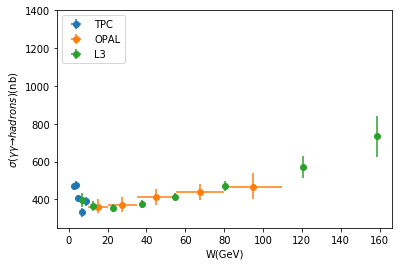

In [9]:
plotGammaGammaSigma([TPC_data, OPAL_data, L3_processed], ["TPC", "OPAL", "L3"])

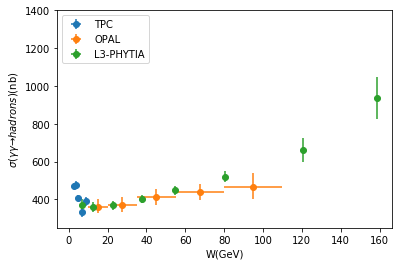

In [10]:
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHYTIA], ["TPC", "OPAL", "L3-PHYTIA"])

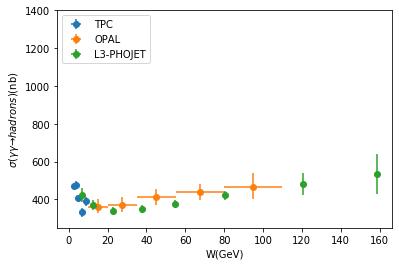

In [11]:
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHOJET], ["TPC", "OPAL", "L3-PHOJET"])

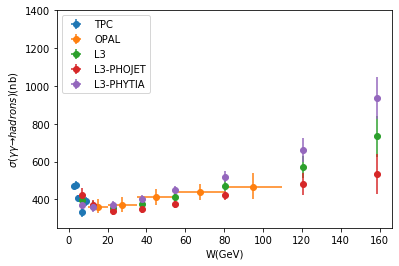

In [12]:
plotGammaGammaSigma([TPC_data, OPAL_data, L3_processed, L3_data_PHOJET, L3_data_PHYTIA],
                    ["TPC", "OPAL", "L3", "L3-PHOJET", "L3-PHYTIA"])

In [13]:
def mergeDataSets(df_list, W_cut = 0):
    """
        This function merges the data frames in df_list in one data_frame.
        The entries of the final data_frame will be ordered by "W(GeV)"
        W_cut will remove data with W < W_cut from the merged data_set
    """
    data = pd.concat(df_list, ignore_index=True)
    data = data[data["W(GeV)"] > W_cut]
    data = data.sort_values(by=["W(GeV)"])
    return data

In [14]:
# Ok now we want to merge the datasets
# Start with L3_processed
data_with_L3_processed = mergeDataSets([TPC_data, OPAL_data, L3_processed])
data_with_L3_processed.to_csv("gammagammaScatteringL3Processed.txt", index = False, sep = '\t')
# Using L3_PHOJET
data_with_L3_PHOJET = mergeDataSets([TPC_data, OPAL_data, L3_data_PHOJET])
data_with_L3_PHOJET.to_csv("gammagammaScatteringL3PHOJET.txt", index = False, sep = '\t')
# Using L3_PHYTIA
data_with_L3_PHYTIA = mergeDataSets([TPC_data, OPAL_data, L3_data_PHYTIA])
data_with_L3_PHYTIA.to_csv("gammagammaScatteringL3PHYTIA.txt", index = False, sep = '\t')

In [15]:
# Unvectorized version of sigmaSoftPomeron
def sigmaSoftPomeronUnvec(W, a, b):
    """
        Computes the total cross section of gamma gamma -> Hadrons
        using the Soft Pomeron Kernel of arXiv:1508.00008.
        The cross section is given by a s^(j0 - 1) + b * s^(j1 - 1),
        where j0 and j1 are the intercepts of the first and second
        Regge trajectories of the Soft Pomeron Kernel and s = W^2
    """
    # Define the intercepts of the Soft Pomeron Kernel
    j0 = 1.0799 
    j1 = 0.428246
    # s = W^2
    s = W ** 2
    sigma = a * s ** (j0 - 1) + b * s ** (j1 -1)
    return sigma
# Vectorized version
sigmaSoftPomeron = np.vectorize(sigmaSoftPomeronUnvec)

# Unvectorized version of sigmaHardPomeron
def sigmaHardPomeronUnvec(W, a, b):
    """
        Computes the total cross section of gamma gamma -> Hadrons
        using the Hard Pomeron Kernel of arXiv:1704.08280 
        using only the first two Reggeons
        The cross section is given by a s^(j0 - 1) + b * s^(j1 - 1),
        where j0 and j1 are the intercepts of the first and second
        Regge trajectories of the Hard Pomeron Kernel and s = W^2
    """
    # Define the intercepts of the Soft Pomeron Kernel
    j0 = 1.17144 
    j1 = 1.08301
    # s = W^2
    s = W ** 2
    sigma = a * s ** (j0 - 1) + b * s ** (j1 -1)
    return sigma
# Vectorized version
sigmaHardPomeron = np.vectorize(sigmaHardPomeronUnvec)

# Unvectorized verson of sigmaHardPomeronFourReggeons
def sigmaHardPomeronFourReggeonsUnvec(W, a, b, c, d):
    """
        Computes the total cross section of gamma gamma -> Hadrons
        using the Hard Pomeron Kernel of arXiv:1704.08280.
        The cross section is given by
        sigma = a s^(j0 - 1) + b * s^(j1 - 1) + c * s^(j2-1) + d * s^(j3 - 1)
        where j0 and j1 are the intercepts of the first and second
        Regge trajectories of the Soft Pomeron Kerne and s = W^2
    """
    # Define the intercepts of the Soft Pomeron Kernel
    j0 = 1.17144 
    j1 = 1.08301
    j2 = 0.974516
    j3 = 0.912894
    # s = W^2
    s = W ** 2
    sigma = a * s ** (j0 - 1) + b * s ** (j1 -1) + c * s ** (j2 - 1) + d * s ** (j3 - 1)
    return sigma
# Vectorized version
sigmaHardPomeronFourReggeons = np.vectorize(sigmaHardPomeronFourReggeonsUnvec)

In [16]:
def chi2SoftPomeron(x, data_frame):
    """
        Computes the chi2 given data in data_frame and two parameters a and b
        chi2 = sum (sigmaPred - sigmaExp)^2 / (sqrt(deltaSigmaExp**2 + deltaSigmaW**2))
        where deltaSigmaW is the uncertainty due to the independent variable W
        x = a, b
    """
    a = x[0]
    b = x[1]
    # Compute sigma using W as the central value
    sigma_central = sigmaSoftPomeron(data_frame["W(GeV)"], a, b)
    # Compute sigma using W as the central values plus the positive error
    sigma_plus = sigmaSoftPomeron(data_frame["W(GeV)"] + data_frame["WErrorp"], a, b)
    # Compute sigma using W as the central value minus the negative error
    sigma_minus = sigmaSoftPomeron(data_frame["W(GeV)"] - data_frame["WErrorm"], a, b)
    deltaSigmaW = np.maximum(np.abs(sigma_plus - sigma_central),np.abs(sigma_central - sigma_minus))
    deltaSigmaExp = np.maximum(data_frame["Errorp"], data_frame["Errorm"])
    s = (sigma_central - data_frame["sigma(nb)"])**2 / (deltaSigmaW ** 2 + deltaSigmaExp ** 2)
    return s.sum()

def chi2HardPomeron(x, data_frame):
    """
        Computes the chi2 given data in data_frame and two parameters a and b
        chi2 = sum (sigmaPred - sigmaExp)^2 / (sqrt(deltaSigmaExp**2 + deltaSigmaW**2))
        where deltaSigmaW is the uncertainty due to the independent variable W
        x = a, b
    """
    a = x[0]
    b = x[1]
    # Compute sigma using W as the central value
    sigma_central = sigmaHardPomeron(data_frame["W(GeV)"], a, b)
    # Compute sigma using W as the central values plus the positive error
    sigma_plus = sigmaHardPomeron(data_frame["W(GeV)"] + data_frame["WErrorp"], a, b)
    # Compute sigma using W as the central value minus the negative error
    sigma_minus = sigmaHardPomeron(data_frame["W(GeV)"] - data_frame["WErrorm"], a, b)
    deltaSigmaW = np.maximum(np.abs(sigma_plus - sigma_central),np.abs(sigma_central - sigma_minus))
    deltaSigmaExp = np.maximum(data_frame["Errorp"], data_frame["Errorm"])
    s = (sigma_central - data_frame["sigma(nb)"])**2 / (deltaSigmaW ** 2 + deltaSigmaExp ** 2)
    return s.sum()

def chi2HardPomeronFourReggeons(x, data_frame):
    """
        Computes the chi2 given data in data_frame and four parameters a, b, c and d
        chi2 = sum (sigmaPred - sigmaExp)^2 / (sqrt(deltaSigmaExp**2 + deltaSigmaW**2))
        where deltaSigmaW is the uncertainty due to the independent variable W
        x = a, b
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    # Compute sigma using W as the central value
    sigma_central = sigmaHardPomeronFourReggeons(data_frame["W(GeV)"], a, b, c, d)
    # Compute sigma using W as the central values plus the positive error
    sigma_plus = sigmaHardPomeronFourReggeons(data_frame["W(GeV)"] + data_frame["WErrorp"], a, b, c, d)
    # Compute sigma using W as the central value minus the negative error
    sigma_minus = sigmaHardPomeronFourReggeons(data_frame["W(GeV)"] - data_frame["WErrorm"], a, b, c, d)
    deltaSigmaW = np.maximum(np.abs(sigma_plus - sigma_central),np.abs(sigma_central - sigma_minus))
    deltaSigmaExp = np.maximum(data_frame["Errorp"], data_frame["Errorm"])
    s = (sigma_central - data_frame["sigma(nb)"])**2 / (deltaSigmaW ** 2 + deltaSigmaExp ** 2)
    return s.sum()

In [17]:
# Start the fit
x0 = np.zeros(2)

Best fit parameters:  a =  200.02082379222534  b =  957.8090159242436
The chi2 / N.d.o.f =  0.8223694481987328


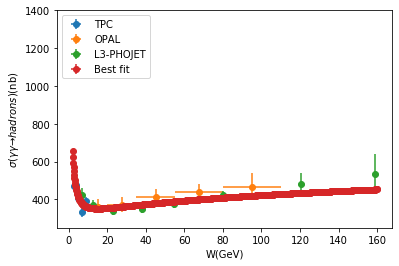

In [18]:
# Best fit with L3_PHOJET full data set with SoftPomeron Kernel
best_fit_x = minimize(chi2SoftPomeron, x0, args = data_with_L3_PHOJET, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2SoftPomeron(best_fit_x, data_with_L3_PHOJET) / (len(data_with_L3_PHOJET)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaSoftPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHOJET, pred], ["TPC", "OPAL", "L3-PHOJET", "Best fit"])

Best fit parameters:  a =  215.15904641431865  b =  788.9506390724775
The chi2 / N.d.o.f =  1.1171813009177192


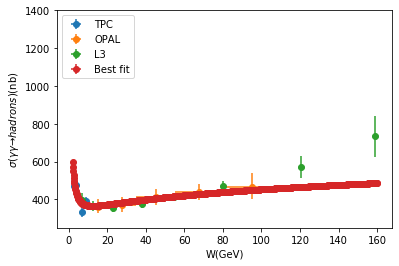

In [19]:
# Best fit with L3_processed full data set with SoftPomeron kernel
best_fit_x = minimize(chi2SoftPomeron, x0, args = data_with_L3_processed, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2SoftPomeron(best_fit_x, data_with_L3_processed) / (len(data_with_L3_processed)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaSoftPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_processed, pred], ["TPC", "OPAL", "L3", "Best fit"])

Best fit parameters:  a =  228.1490248368624  b =  676.5513776778223
The chi2 / N.d.o.f =  2.229614399023274


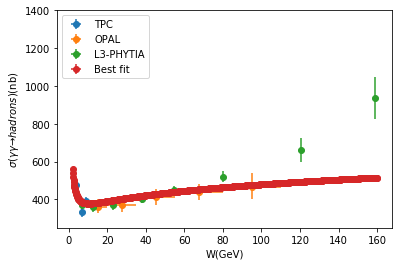

In [20]:
# Best fit with L3_PHYTIA full data set with SoftPomeron
best_fit_x = minimize(chi2SoftPomeron, x0, args = data_with_L3_PHYTIA, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2SoftPomeron(best_fit_x, data_with_L3_PHYTIA) / (len(data_with_L3_PHYTIA)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaSoftPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHYTIA, pred], ["TPC", "OPAL", "L3-PHYTIA", "Best fit"])

In [21]:
# Form new data sets without TPC data and using points with W > 20
data_with_L3_processed_no_TPC = mergeDataSets([OPAL_data, L3_processed], 20)
data_with_L3_PHYTIA_no_TPC = mergeDataSets([OPAL_data, L3_data_PHYTIA], 20)
data_with_L3_PHOJET_no_TPC = mergeDataSets([OPAL_data, L3_data_PHOJET], 20)

Best fit parameters:  a =  21.19767288097356  b =  158.62113581164516
The chi2 / N.d.o.f =  0.4558693562793052


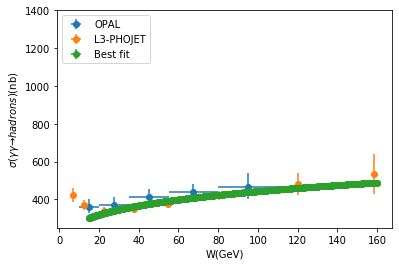

In [22]:
# Best fit with L3_PHOJET and without TPC data set with HardPomeron Kernel
best_fit_x = minimize(chi2HardPomeron, x0, args = data_with_L3_PHOJET_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2HardPomeron(best_fit_x, data_with_L3_PHOJET_no_TPC) / (len(data_with_L3_PHOJET_no_TPC)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(15,160,1000)
sigma = sigmaHardPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_data_PHOJET, pred], ["OPAL", "L3-PHOJET", "Best fit"])

Best fit parameters:  a =  66.01655200981448  b =  85.57628408663197
The chi2 / N.d.o.f =  0.5717002728760734


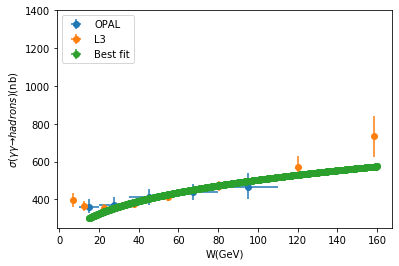

In [23]:
# Best fit with L3_processed and without TPC data set with HardPomeron Kernel
best_fit_x = minimize(chi2HardPomeron, x0, args = data_with_L3_processed_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2HardPomeron(best_fit_x, data_with_L3_processed_no_TPC) / (len(data_with_L3_processed_no_TPC)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(15,160,1000)
sigma = sigmaHardPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_processed, pred], ["OPAL", "L3", "Best fit"])

Best fit parameters:  a =  114.91559352708617  b =  4.742446713885153
The chi2 / N.d.o.f =  1.3744249035157785


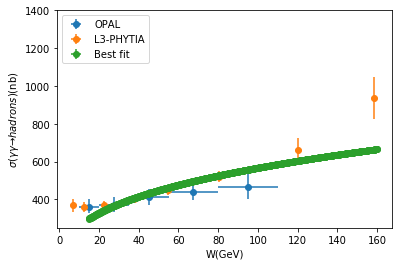

In [24]:
# Best fit with L3_PHYTIA and without TPC data set with HardPomeron Kernel
best_fit_x = minimize(chi2HardPomeron, x0, args = data_with_L3_PHYTIA_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1])
chi2_ndof = chi2HardPomeron(best_fit_x, data_with_L3_PHYTIA_no_TPC) / (len(data_with_L3_PHYTIA_no_TPC)-2)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(15,160,1000)
sigma = sigmaHardPomeron(Ws, best_fit_x[0], best_fit_x[1])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_data_PHYTIA, pred], ["OPAL", "L3-PHYTIA", "Best fit"])

Best fit parameters:  a =  -97.83757956685119  b =  318.0062585396297  c =  116.07903158024376  d =  99.70008570990966
The chi2 / N.d.o.f =  5.784130018548547


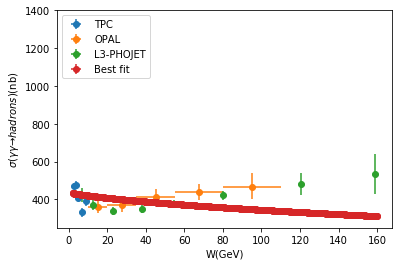

In [32]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_PHOJET, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_PHOJET) / (len(data_with_L3_PHOJET)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHOJET, pred], ["TPC", "OPAL", "L3-PHOJET", "Best fit"])

Best fit parameters:  a =  -80.24761572592593  b =  302.89682779644124  c =  110.8518866367295  d =  90.53687405228722
The chi2 / N.d.o.f =  7.035275023655616


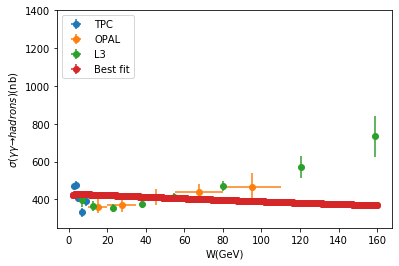

In [34]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_processed, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_processed) / (len(data_with_L3_processed)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_processed, pred], ["TPC", "OPAL", "L3", "Best fit"])

Best fit parameters:  a =  -981.2017042214868  b =  5515.894385773868  c =  -14472.865931341792  d =  10887.37748041868
The chi2 / N.d.o.f =  1.973222702680893


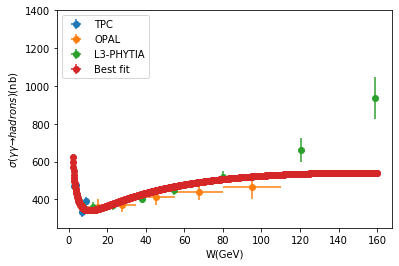

In [35]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_PHYTIA, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_PHYTIA) / (len(data_with_L3_PHYTIA)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([TPC_data, OPAL_data, L3_data_PHYTIA, pred], ["TPC", "OPAL", "L3-PHYTIA", "Best fit"])

Best fit parameters:  a =  294.51270671725433  b =  -763.6530320362833  c =  581.0546404684712  d =  464.9511435857418
The chi2 / N.d.o.f =  0.41060038523416836


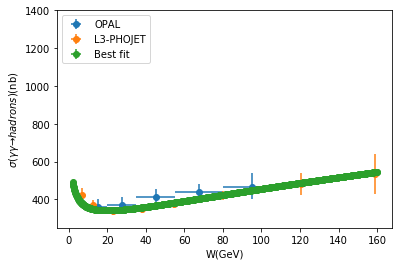

In [36]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_PHOJET_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_PHOJET_no_TPC) / (len(data_with_L3_PHOJET_no_TPC)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_data_PHOJET, pred], ["OPAL", "L3-PHOJET", "Best fit"])

Best fit parameters:  a =  45.272565314844215  b =  135.53637554247797  c =  69.46944404188261  d =  -143.08032020240617
The chi2 / N.d.o.f =  0.828525752011989


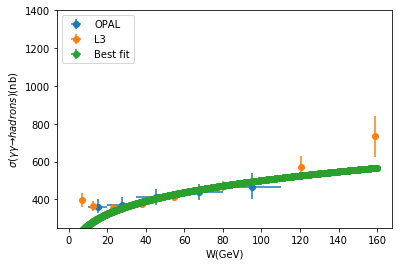

In [39]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_processed_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_processed_no_TPC) / (len(data_with_L3_processed_no_TPC)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_processed, pred], ["OPAL", "L3", "Best fit"])

Best fit parameters:  a =  785.7970126991215  b =  -2191.003167718889  c =  1023.9317354854766  d =  1530.8396939551658
The chi2 / N.d.o.f =  0.6739723837777792


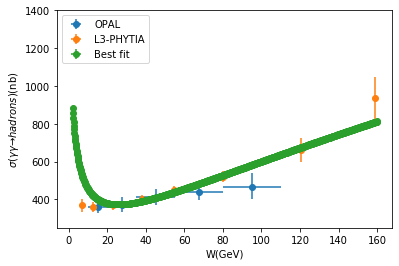

In [40]:
# Let's repeat the fits with the all datasets but allowing the 4 Regge trajectories of the HardPomeron Kernel
x0 = np.zeros(4)
best_fit_x = minimize(chi2HardPomeronFourReggeons, x0, args = data_with_L3_PHYTIA_no_TPC, method = "Nelder-Mead").x
print("Best fit parameters: ","a = ", best_fit_x[0], " b = ", best_fit_x[1],
     " c = ", best_fit_x[2], " d = ", best_fit_x[3])
chi2_ndof = chi2HardPomeronFourReggeons(best_fit_x, data_with_L3_PHYTIA_no_TPC) / (len(data_with_L3_PHYTIA_no_TPC)-4)
print("The chi2 / N.d.o.f = ", chi2_ndof)
Ws = np.linspace(2,160,1000)
sigma = sigmaHardPomeronFourReggeons(Ws, best_fit_x[0], best_fit_x[1], best_fit_x[2], best_fit_x[3])
pred = pd.DataFrame({"W(GeV)":Ws,
                    "WErrorp": np.zeros(len(Ws)),
                    "WErrorm": np.zeros(len(Ws)),
                    "sigma(nb)": sigma,
                    "Errorp": np.zeros(len(Ws)),
                    "Errorm": np.zeros(len(Ws))})
plotGammaGammaSigma([OPAL_data, L3_data_PHYTIA, pred], ["OPAL", "L3-PHYTIA", "Best fit"])